notebook to plot data from `NT_Src` and hopefully repeat the calculations in python

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
source_dir = '../../CDMS/supersim/CDMSsources/spectra/neutron/'

source_files = {'U': 'norite_2013_U_1ppb.dat', 'Th': 'norite_2013_Th_1ppb.dat'}

data_file = 'data/V1/data_Norite_100_Sg.dat'

In [68]:
dat = pd.read_csv(data_file,sep = ' ', index_col = 0, names = ['Eg', 'Sg'])

Eg = dat.Eg.values
Sg = dat.Sg.values
gs = dat.index

def plottable(E, S):
    return (E[1:] + E[:-1])/2, S[1:]

In [69]:
src_dfs = {Z: pd.read_csv(source_dir + source_files[Z], sep = '\t', index_col = False, names = ['E', 'spec']) for Z in source_files}

EU = src_dfs['U'].E.values
specU = src_dfs['U'].spec.values
ETh = src_dfs['Th'].E.values
specTh = src_dfs['Th'].spec.values

if all(EU==ETh):
    spec = (1.095)*specU + (5.715)*specTh

In [70]:
def interp(x, x1, y1, x2, y2):
    return y1 + (x-x1)*(y2-y1)/(x2-x1)

def trap(x, y):
    return ((y[1:] + y[:-1])*(x[1:] - x[:-1])).sum()/2

In [71]:
Sg2 = np.zeros(Sg.shape)
minE = EU[0]
maxE = EU[-1]

for g in range(1,len(Sg)):
    gmin = Eg[g]
    gmax = Eg[g-1]
    if gmax < minE or maxE < gmin:
        continue

    idx = np.where((gmin < EU)*(EU < gmax))[0]

    E_eval = list(EU[idx])
    S_eval = list(spec[idx])

    id_less = np.where(EU < gmin)[0]
    if len(id_less) > 0:
        E_eval = [gmin] + E_eval
        i = id_less[-1]
        S1 = interp(gmin, EU[i], spec[i], EU[i+1], spec[i+1])
        S_eval = [S1] + S_eval
        
    id_greater = np.where(gmax < EU)[0]
    if len(id_greater) > 0:
        E_eval = E_eval + [gmax]
        i = id_greater[0]
        S2 = interp(gmax, EU[i-1], spec[i-1], EU[i], spec[i])
        S_eval = S_eval + [S2]


    E_eval = np.array(E_eval)
    S_eval = np.array(S_eval)

    Sg2[g] = trap(E_eval, S_eval)/(gmax - gmin)


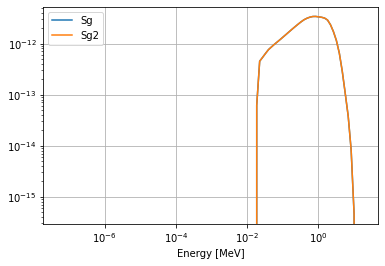

In [72]:
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('Energy [MeV]')

plt.plot(*plottable(Eg, Sg), label = 'Sg')
plt.plot(*plottable(Eg, Sg2), label = 'Sg2')

plt.legend()

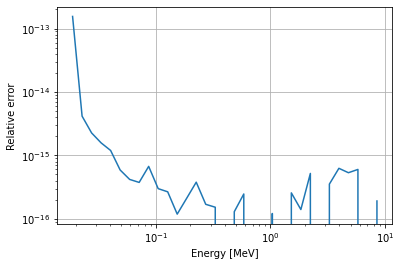

In [73]:
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('Energy [MeV]')
plt.ylabel('Relative error')
nz = Sg != 0
plt.plot(*plottable(Eg[nz], abs(Sg[nz]-Sg2[nz])/Sg[nz]))

In [74]:
all((Sg == 0) == (Sg2 == 0))

True

In [75]:
oops = np.where((Sg == 0) != (Sg2 == 0))
oops

(array([], dtype=int64),)

In [76]:
Sg[4], Sg2[4]

(4.555804216753166e-16, 4.555804216753169e-16)

In [77]:
Eg[4], Eg[3]

(9.310838545560264, 11.271951093403215)

In [78]:
EU[-3:]

array([ 9.96,  9.98, 10.  ])